In [ ]:
import xarray as xr
import yaml
import numpy as np
import remap_tools  # local package to outsource the remap functions
import zarr_tools
import logging
from pathlib import Path

In [2]:
logging.basicConfig()
logger = logging.getLogger("icon2zarr")
logger.setLevel(logging.INFO)

In [3]:
infiles = [
    "/work/mh0287/m211032/Icon/Git_lev/icon.XPP.20240717/build.intel-hdint/experiments/slo1774/slo1774_atm_2d_ml_16100101T000000Z.nc",
    "/work/mh0287/m211032/Icon/Git_lev/icon.XPP.20240717/build.intel-hdint/experiments/slo1774/slo1774_atm_2d_ml_14900101T000000Z.nc",
]

In [ ]:
def convert_files(zoom, subset, output_dir, config):
    files = infiles
    outfile = Path(f"{output_dir}/ICON_{subset}_z{zoom}.zarr")
    curr_conf = config[subset]
    timechunk = curr_conf["chunks"]["time"]

    ds = xr.open_mfdataset(files, chunks=curr_conf["chunks"], use_cftime=True)
    out_ds = process_2d(curr_conf, ds)
    out_ds = remap_tools.remap_delaunay(out_ds, zoom)
    logger.info(f"Trying to write to {outfile}")
    zarr_tools.create_zarr_structure(
        path=outfile, outds=out_ds, timechunk=timechunk, order=zoom
    )
    zarr_tools.write_parts(outds=out_ds, path=outfile, time_chunk=24)
    return out_ds, outfile


def process_2d(curr_conf, ds):
    ds = ds.rename(curr_conf["renames"])
    ds = ds.isel(curr_conf["isel"])
    ds = ds.drop_vars(list(curr_conf["isel"]) + curr_conf["drop"])
    ds["lon"] = np.rad2deg(ds["lon"])
    ds["lat"] = np.rad2deg(ds["lat"])
    return ds


def process_3d(curr_conf, ds):
    ds = ds.rename(curr_conf["renames"])
    return ds

In [5]:
output_dir = "/scratch/k/k202134/icon_remapped"
config = yaml.safe_load(open("icon_to_zarr.yaml"))
for subset in ("2d",):
    for zoom in (5,):
        out_ds, outfile = convert_files(
            zoom=zoom, subset=subset, output_dir=output_dir, config=config
        )

INFO:icon2zarr:Trying to write to /scratch/k/k202134/icon_remapped/ICON_2d_z5.zarr
INFO:zarr_tools:Processed time steps starting at 0
INFO:zarr_tools:Processed time steps starting at 24
INFO:zarr_tools:Processed time steps starting at 48
INFO:zarr_tools:Processed time steps starting at 72
INFO:zarr_tools:Processed time steps starting at 96
INFO:zarr_tools:Processed time steps starting at 120
INFO:zarr_tools:Processed time steps starting at 144
INFO:zarr_tools:Processed time steps starting at 168
INFO:zarr_tools:Processed time steps starting at 192
INFO:zarr_tools:Processed time steps starting at 216


/home/k/k202134/python-envs/easy/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/k/k202134/python-envs/easy/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


<Figure size 640x480 with 0 Axes>

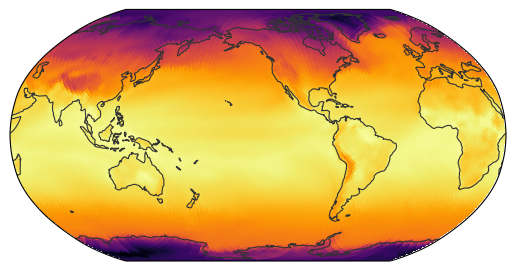

In [6]:
import easygems.healpix as egh

egh.healpix_show(
    xr.open_dataset(outfile, use_cftime=True)["t_s"].isel(time=2), cmap="inferno"
)